# Plot DO concentration

In [1]:
import sys
import os
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

In [2]:
dti = pandas.date_range("2014-01-01", periods=367, freq="D")
model_day = dti[10]


Timestamp('2014-01-11 00:00:00', freq='D')

In [23]:
if (model_day == pandas.Timestamp(date(2014,1,11))) or \
   (model_day == pandas.Timestamp(date(2014,1,10))):
    print('yes')

yes


In [2]:
root_dir=pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/SOG_NB/")
model_var = "DOXG"
run = "wqm_baseline"

run_file = root_dir/model_var/run/"daily_min_DOXG.nc"

# Load config file
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']
    
# Loast shapefile 
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

# Load minimum DO results from scenario
MinDO={}

with xarray.open_dataset(run_file) as ds:
    print([*ds])
    MinDO_full=ds[f'DOXG_daily_min']
    # Sub-sample nodes (from 16012 nodes to 7494)
    MinDO=MinDO_full[:,:,gdf['node_id']-1]
    # Take minimum across depth levels
    MinDO_wc = MinDO.min(axis=1)

['DOXG_daily_min']


In [3]:
np.ceil(np.max(np.max(MinDO_wc))).item()

13.0

### Plot results

In [4]:
np.ceil(MinDO_wc.max().item())

13.0

In [5]:
day=200
# set all values over 7 to the maximum DO concentration
max_idx=(MinDO_wc[day,:]>7)
MinDO_wc[day,max_idx]=MinDO_wc.max().item()
min_idx=(MinDO_wc[day,:]<2)
MinDO_wc[day,min_idx]=0

In [6]:
gdf['DO'] = MinDO_wc[day,:]

In [7]:
[*gdf]

['tce',
 'node_id',
 'x',
 'y',
 'lat',
 'lon',
 'DO_std',
 'depth',
 'km2',
 'volume',
 'basin_info',
 'Regions',
 'included_i',
 'Shape_Leng',
 'Shape_Area',
 'geometry',
 'DO']

In [8]:
gdf=gdf[gdf['Regions']=="Whidbey"]

In [9]:
gdf.shape

(531, 17)

0 2
2 3
3 4
4 5
5 6
6 7
7 12.11


Text(0.5, 1.0, 'Minimum Daily Dissolved Oxygen (DO)\nDay 200 of 2014')

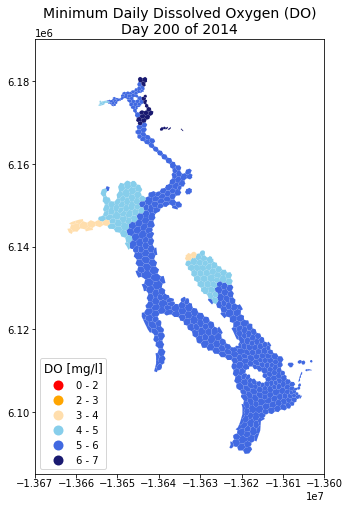

In [29]:
mpl.rc('font', size=10)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('legend', fontsize=10)
mpl.rc('axes', titlesize=14)
mpl.rc('axes', labelsize=10)
mpl.rc('figure', titlesize=10)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

fig, axs = plt.subplots(1, figsize = (8,8))
gdf.plot(ax=axs,
        column='DO',
        scheme="User_Defined", 
        legend=True, 
        classification_kwds=dict(bins=[2,3,4,5,6,7]),
        cmap=mpl.colors.ListedColormap(
            ['red','orange','navajowhite','beige','skyblue','royalblue','midnightblue'])
        )
# remove x-, y-labels
#axs.set_xticklabels('')
#axs.set_yticklabels('')
axs.set_ylim(6.085e6,6.19e6)
axs.set_xlim(-1.367e7,-1.36e7)
# set legend to lower left corner (instead of default upper-right, which overlaps SOGNB)
#axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt_legend = axs.get_legend()
plt_legend.set_bbox_to_anchor=(1,1)
plt_legend._loc = 3
plt_legend.set_title('DO [mg/l]')
# # get all the legend labels
# legend_labels = axs.get_legend().get_texts()
# Change legend label format from 0.00, 2.00 to 0-2
# get and format all bounds
bounds = []
upper_bounds=[2,3,4,5,6,7,12.11]
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = 0
    else:
        lower_bound = upper_bounds[index-1]
    print(lower_bound, upper_bound)
    
    # format the numerical legend here
    bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
    bounds.append(bound)
# get all the legend labels
legend_labels = axs.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
    
# # replace the legend labels
# for bound, legend_label in zip(bounds, legend_labels):
#     legend_label.set_text(bound)
# Add land topography
# cx.add_basemap(axs, 
#     crs=gdf.crs,
#     source=cx.providers.Stamen.TerrainBackground, 
#     alpha=1
# )

# cx.add_basemap(
#     axs,
#     crs=gdf.crs,
#     source=cx.providers.Stamen.TerrainLabels, 
#     zoom=10)
axs.set_title(f'Minimum Daily Dissolved Oxygen (DO)\nDay {day} of 2014')

In [31]:
gdf.to_file('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/EOPS/DO_200.geojson', driver='GeoJSON')  

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [32]:
gdf.to_file('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/EOPS/DO_200.shp')  

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [33]:
[*gdf]

['tce',
 'node_id',
 'x',
 'y',
 'lat',
 'lon',
 'DO_std',
 'depth',
 'km2',
 'volume',
 'basin_info',
 'Regions',
 'included_i',
 'Shape_Leng',
 'Shape_Area',
 'geometry',
 'DO']

In [36]:
gdf_small = gdf[['DO','geometry', 'lat','lon']]
gdf_small.to_file('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/EOPS/DO_200_small.shp')
gdf_small.to_file('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/EOPS/DO_200_small.geojson', driver='GeoJSON')  

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
ssm['paths']['processed_output']

In [ ]:
# get and format all bounds
bounds = []
upper_bounds=[2,3,4,5,6,7,12.11]
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = 0
    else:
        lower_bound = upper_bounds[index-1]
    print(lower_bound, upper_bound)
    
    # format the numerical legend here
    bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = axs.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)